# 马尔科夫链：基本概念

```{index} single: 马尔科夫链: 基本概念与平稳性
```

除了 Anaconda 中的库之外，本讲座还需要以下库：

In [1]:
!pip install quantecon

## 概述

马尔科夫链提供了一种对过去对未来产生影响的情况进行建模的方法。

我们的意思是，观察当前情况的一些测量值可以帮助我们预测未来的情况。

当在不同时间点对某事物的测量之间存在统计依赖时，这可能是可能的。

例如，

* 明年的通货膨胀可能与今年的通货膨胀共同变化
* 下个月的失业率可能与本月的失业率共同变化

马尔科夫链是经济学和金融学的一个重要工具。

马尔科夫链理论是美丽的，并为概率和动态提供了许多见解。

在本讲座中，我们将

* 回顾马尔科夫链理论中的一些关键思想，及
* 展示马尔科夫链在一些经济应用中的出现方式。

让我们从一些标准导入开始：

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
import networkx as nx
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## 定义与示例

在本节中，我们将提供一些定义和基本示例。

(finite_dp_stoch_mat)=
### 随机矩阵

回想一下，**概率质量函数**是一个 $n$ 个可能结果上的非负 $n$-维向量 $p$，其总和为 1。

例如，$p = (0.2, 0.2, 0.6)$ 是一个三个结果上的概率质量函数。

**随机矩阵**（或**马尔科夫矩阵**）是一个 $n \times n$ 的方阵 $P$，其中 $P$ 的每一行都是一个 $n$ 个结果上的概率质量函数。

换句话说，

1. $P$ 的每个元素都是非负的，且
1. $P$ 的每一行的和为 1

如果 $P$ 是一个随机矩阵，则对于所有 $k \in \mathbb N$，$P^k$ 也是一个随机矩阵。

你将在{ref}`一个练习 <mc1_ex_3>`中验证这一点。

### 马尔科夫链

现在我们可以引入马尔科夫链。

在严格定义马尔科夫链之前，我们先给出一些示例。

(mc_eg2)=
#### 示例 1

根据美国失业数据，Hamilton {cite}`Hamilton2005` 估计了以下动态。

```{image} /_static/lecture_specific/markov_chains_I/Hamilton.png
:name: mc_hamilton
:align: center
```

这里有三个**状态**：

* "ng" 表示正常增长
* "mr" 表示轻度衰退
* "sr" 表示严重衰退

箭头代表一个月内的转移概率。

例如，从轻度衰退到正常增长的箭头旁边有 0.145。

这告诉我们，根据过去的数据，从轻度衰退转移到正常增长的概率为 14.5%。

从正常增长回到正常增长的箭头告诉我们，从正常增长转移到正常增长（保持在同一状态）的概率为 97%。

请注意，这些是条件概率——从一个状态转移到另一个状态（或保持在同一状态）的概率是以当前状态为条件的。

为了便于数值处理，让我们将状态转换为数字。

具体来说，我们约定

* 状态 0 代表正常增长
* 状态 1 代表轻度衰退
* 状态 2 代表严重衰退

令 $X_t$ 记录时间 $t$ 时的状态值。

现在我们可以将“轻度衰退转移到正常增长的概率为 14.5%”的陈述写为

$$
    \mathbb P\{X_{t+1} = 0 \,|\, X_t = 1\} = 0.145
$$

我们可以将所有这些条件概率收集到一个矩阵中，如下所示：

$$
P =
\begin{bmatrix}
0.971 & 0.029 & 0 \\
0.145 & 0.778 & 0.077 \\
0 & 0.508 & 0.492
\end{bmatrix}
$$

注意，$P$ 是一个随机矩阵。

现在我们有以下关系：

$$
    P(i,j)
    = \mathbb P\{X_{t+1} = j \,|\, X_t = i\}
$$

这对于任何 $i,j$ 在 0 到 2 之间都成立。

在此，$P(i,j)$ 是从状态 $i$ 转移到状态 $j$ 在一个月内的概率。

(mc_eg1)=
#### 示例 2

考虑一个工人，在任何给定时间 $t$，他要么失业（状态 0），要么就业（状态 1）。

假设在一个月内，

1. 失业的工人以概率 $\alpha \in (0, 1)$ 找到工作。
1. 就业的工人以概率 $\beta \in (0, 1)$ 失去工作并变得失业。

根据上述信息，我们可以将转移概率写成矩阵形式

```{math}
:label: p_unempemp

P =
\begin{bmatrix}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{bmatrix}
```

例如，

$$
\begin{aligned}
    P(0,1)
        & =
        \text{ 从状态 $0$ 转移到状态 $1$ 的概率（一个月内）}
        \\
        & =
        \text{ 找到下个月工作的概率}
        \\
        & = \alpha
\end{aligned}
$$

假设我们可以估计 $\alpha$ 和 $\beta$ 的值。

那么我们可以解决一系列问题，例如

* 失业的平均持续时间是多少？
* 从长期来看，工人失业的时间占总时间的多少？
* 在就业的条件下，工人在接下来的 12 个月内至少失业一次的概率是多少？

我们将在下面讨论其中一些应用。

(mc_eg3)=
#### 示例 3

Imam 和 Temple {cite}`imampolitical` 将政治制度分类为三种类型：民主 $\text{(D)}$，专制 $\text{(A)}$ 和一个称为无政府状态的中间状态 $\text{(N)}$。

每种制度都可以有两种可能的发展模式：崩溃 $\text{(C)}$ 和增长 $\text{(G)}$。这导致了六种可能的状态：$\text{DG, DC, NG, NC, AG}$ 和 $\text{AC}$。

Imam 和 Temple {cite}`imampolitical` 估计了以下转移概率：

$$
P :=
\begin{bmatrix}
0.86 & 0.11 & 0.03 & 0.00 & 0.00 & 0.00 \\
0.52 & 0.33 & 0.13 & 0.02 & 0.00 & 0.00 \\
0.12 & 0.03 & 0.70 & 0.11 & 0.03 & 0.01 \\
0.13 & 0.02 & 0.35 & 0.36 & 0.10 & 0.04 \\
0.00 & 0.00 & 0.09 & 0.11 & 0.55 & 0.25 \\
0.00 & 0.00 & 0.09 & 0.15 & 0.26 & 0.50
\end{bmatrix}
$$

In [3]:
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]

下面是可视化图，颜色越深表示概率越高。

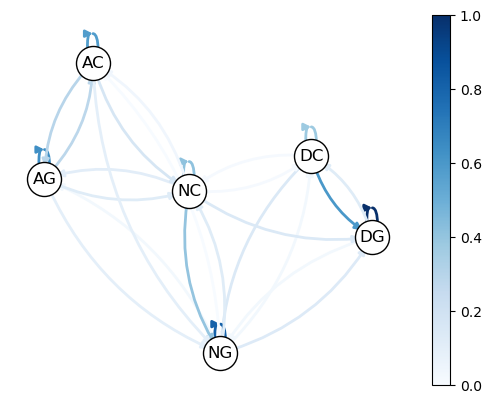

In [4]:
G = nx.MultiDiGraph()

for start_idx, node_start in enumerate(nodes):
    for end_idx, node_end in enumerate(nodes):
        value = P[start_idx][end_idx]
        if value != 0:
            G.add_edge(node_start,node_end, weight=value)

pos = nx.spring_layout(G, seed=10)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, node_size=600, edgecolors='black', node_color='white')
nx.draw_networkx_labels(G, pos)

arc_rad = 0.2

edges = nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle=f'arc3, rad = {arc_rad}', edge_cmap=cm.Blues, width=2,
    edge_color=[G[nodes[0]][nodes[1]][0]['weight'] for nodes in G.edges])

pc = mpl.collections.PatchCollection(edges, cmap=cm.Blues)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

查看数据后，我们发现民主政体的增长期通常比专制政体更长（这体现在专制政体中从增长到增长的转移概率较低）。

我们还可以发现，在民主政体中，从崩溃到增长的概率较高。

### 定义马尔科夫链

到目前为止，我们已经给出了马尔科夫链的示例，但还没有对其进行定义。

现在让我们进行定义。

首先，设 $S$ 是一个有限集合 $\{x_1, \ldots, x_n\}$，其中包含 $n$ 个元素。

集合 $S$ 被称为**状态空间**，$x_1, \ldots, x_n$ 被称为**状态值**。

一个分布 $\psi$ 在 $S$ 上是一个长度为 $n$ 的概率质量函数，其中 $\psi(i)$ 是分配给状态 $x_i$ 的概率。

在 $S$ 上的**马尔科夫链** $\{X_t\}$ 是一个取值于 $S$ 的随机变量序列，且具有**马尔科夫性质**。

这意味着，对于任何时间 $t$ 和任何状态 $y \in S$，

```{math}
:label: fin_markov_mp

\mathbb P \{ X_{t+1} = y  \,|\, X_t \}
= \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \}
```

这意味着一旦我们知道当前状态 $X_t$，添加之前状态 $X_{t-1}, X_{t-2}$ 的知识不会对未来状态的概率提供额外信息。

因此，马尔科夫链的动态完全由**条件概率**集合决定：

```{math}
:label: mpp

P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
\qquad (x, y \in S)
```

根据构造，

* $P(x, y)$ 是从 $x$ 到 $y$ 在一个时间单位（一步）内的转移概率
* $P(x, \cdot)$ 是给定 $X_t = x$ 时，$X_{t+1}$ 的条件分布

我们可以将 $P$ 视为一个随机矩阵，其中

$$
    P_{ij} = P(x_i, x_j)
    \qquad 1 \leq i, j \leq n
$$

反过来，如果我们取一个随机矩阵 $P$，我们可以按如下方式生成一个马尔科夫链 $\{X_t\}$：

* 从 $S$ 上的分布 $\psi_0$ 中抽取 $X_0$
* 对于每个 $t = 0, 1, \ldots$，从 $P(X_t, \cdot)$ 中抽取 $X_{t+1}$

通过构造，所得的过程满足 {eq}`mpp`。


## 模拟

```{index} single: 马尔科夫链; 模拟
```

研究马尔科夫链的一个好方法是模拟它们。

让我们先自己做这个，然后再看看可以帮助我们的库。

在这些练习中，我们将状态空间设为 $S = 0,\ldots, n-1$。

（我们从 $0$ 开始，因为 Python 数组是从 $0$ 索引的。）


### 编写我们自己的模拟代码

要模拟一个马尔科夫链，我们需要

1. 一个随机矩阵 $P$ 和
1. 一个长度为 $n$ 的概率质量函数 $\psi_0$，从中抽取 $X_0$ 的初始实现。

然后马尔科夫链按照如下方式构建：

1. 在时间 $t=0$，从分布 $\psi_0$ 中抽取 $X_0$ 的一个实现。
1. 在每个后续时间 $t$，从 $P(X_t, \cdot)$ 中抽取一个新状态 $X_{t+1}$ 的实现。

（也就是说，从 $P$ 的第 $X_t$ 行中抽取。）

要实现这个模拟过程，我们需要一种方法从离散分布中生成抽取结果。

对于这个任务，我们将使用 [QuantEcon.py](http://quantecon.org/quantecon-py) 中的 `random.draw`。

要使用 `random.draw`，我们首先需要将概率质量函数转换为累积分布。

In [5]:
ψ_0 = (0.3, 0.7)           # {0, 1} 上的概率分布
cdf = np.cumsum(ψ_0)       # 转换为累积分布
qe.random.draw(cdf, 5)   # 从 ψ 中生成 5 个独立抽取

array([1, 1, 1, 0, 0])

我们将编写一个函数，该函数接受以下三个参数：

* 随机矩阵 `P`。
* 初始分布 `ψ_0`。
* 正整数 `ts_length`，表示函数应返回的时间序列的长度。

In [6]:
def mc_sample_path(P, ψ_0=None, ts_length=1_000):

    # 设置
    P = np.asarray(P)
    X = np.empty(ts_length, dtype=int)

    # 将 P 的每一行转换为累积分布函数（cdf）
    P_dist = np.cumsum(P, axis=1)  # 将行转换为 cdf

    # 抽取初始状态，默认为 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # 模拟
    X[0] = X_0
    for t in range(ts_length - 1):
        X[t+1] = qe.random.draw(P_dist[X[t], :])

    return X

让我们看看它是如何工作的，使用一个小的矩阵

In [7]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

以下是一个短的时间序列。

In [8]:
mc_sample_path(P, ψ_0=(1.0, 0.0), ts_length=10)

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1])

可以证明，从矩阵 `P` 中生成的长序列中，取值为 0 的样本占比将约为 0.25。

（我们将在{ref}`稍后 <ergodicity>`解释为什么。）

而且，这与 $X_0$ 是从哪个初始分布中抽取的无关。

下面的代码演示了这一点

In [9]:
X = mc_sample_path(P, ψ_0=(0.1, 0.9), ts_length=1_000_000)
np.mean(X == 0)

0.250653

您可以尝试更改初始分布，以确认输出总是接近 0.25（对于上述矩阵 `P`）。


### 使用 QuantEcon 的例程

[QuantEcon.py](http://quantecon.org/quantecon-py) 提供了一些处理马尔科夫链的例程，包括模拟。

以下是使用与前例相同的 $P$ 的说明

In [10]:
mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.249887

`simulate` 例程速度更快（因为它是 [JIT 编译](https://python-programming.quantecon.org/numba.html#numba-link) 的）。

In [11]:
%time mc_sample_path(P, ts_length=1_000_000) # 我们自制的代码版本

CPU times: user 1.18 s, sys: 142 μs, total: 1.18 s
Wall time: 1.18 s


array([0, 0, 1, ..., 1, 0, 0])

In [12]:
%time mc.simulate(ts_length=1_000_000) # qe 代码版本

CPU times: user 10.5 ms, sys: 3.89 ms, total: 14.4 ms
Wall time: 14 ms


array([0, 0, 0, ..., 1, 1, 1])

#### 添加状态值和初始条件

如果需要，我们可以向 `MarkovChain` 提供状态值的规范。

这些状态值可以是整数、浮点数，甚至是字符串。

以下代码说明了这一点

In [13]:
mc = qe.MarkovChain(P, state_values=('失业', '就业'))
mc.simulate(ts_length=4, init='就业')  # 从就业初始状态开始

array(['就业', '就业', '就业', '就业'], dtype='<U2')

In [14]:
mc.simulate(ts_length=4, init='失业')  # 从失业初始状态开始

array(['失业', '失业', '就业', '失业'], dtype='<U2')

In [15]:
mc.simulate(ts_length=4)  # 从随机选择的初始状态开始

array(['失业', '就业', '就业', '就业'], dtype='<U2')

如果我们希望看到索引而不是状态值作为输出，我们可以使用

In [16]:
mc.simulate_indices(ts_length=4)

array([0, 1, 1, 1])

(mc_md)=
## 随时间分布

我们了解到

1. $\{X_t\}$ 是一个具有随机矩阵 $P$ 的马尔科夫链
1. $X_t$ 的分布已知为 $\psi_t$

那么，$X_{t+1}$ 的分布是什么？更一般地，$X_{t+m}$ 的分布是什么？

为了回答这个问题，令 $\psi_t$ 为 $X_t$ 的分布，$t = 0, 1, 2, \ldots$。

我们的第一个目标是找到给定 $\psi_t$ 和 $P$ 时的 $\psi_{t + 1}$。

首先，选择任意 $y \in S$。

为了得到明天（$t+1$ 时）在 $y$ 的概率，我们计算所有可能发生的方式，并对它们的概率求和。

这导致了

$$
\mathbb P \{X_{t+1} = y \}
   = \sum_{x \in S} \mathbb P \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb P \{ X_t = x \}
$$



（我们正在使用[全概率公式](https://en.wikipedia.org/wiki/Law_of_total_probability)。）

将这一陈述重新写为边际概率和条件概率的形式：

$$
    \psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
$$

有 $n$ 个这样的方程，每个 $y \in S$ 对应一个方程。

如果我们将 $\psi_{t+1}$ 和 $\psi_t$ 视为行向量，则这 $n$ 个方程可通过矩阵表达式总结为

```{math}
:label: fin_mc_fr

\psi_{t+1} = \psi_t P
```

因此，我们通过右乘 $P$ 将分布向前移动一个时间单位。

通过右乘 $m$ 次，我们将分布向前移动 $m$ 步进入未来。

因此，迭代 {eq}`fin_mc_fr`，表达式 $\psi_{t+m} = \psi_t P^m$ 也是有效的——这里 $P^m$ 是 $P$ 的第 $m$ 次幂。

作为一个特例，我们看到，如果 $\psi_0$ 是从中抽取 $X_0$ 的初始分布，则 $\psi_0 P^m$ 是 $X_m$ 的分布。

这非常重要，所以我们重复一下

```{math}
:label: mdfmc

X_0 \sim \psi_0 \quad \implies \quad X_m \sim \psi_0 P^m
```

一般规则是通过右乘 $P^m$ 将分布向前移动 $m$ 个时间单位。

因此，以下也是有效的。

```{math}
:label: mdfmc2

X_t \sim \psi_t \quad \implies \quad X_{t+m} \sim \psi_t P^m
```

(finite_mc_mstp)=
### 多步转移概率

我们知道，从 $x$ 到 $y$ 的一步转移概率是 $P(x,y)$。

实际上，从 $x$ 到 $y$ 的 $m$ 步转移概率是 $P^m(x,y)$，即 $P$ 的 $m$ 次方的 $(x,y)$ 元素。

要理解为什么是这样，请再次考虑 {eq}`mdfmc2`，但现在设 $\psi_t$ 将所有概率都放在状态 $x$ 上。

此时，$\psi_t$ 是一个在 $x$ 位置为 $1$，在其他地方为 $0$ 的向量。

将其代入 {eq}`mdfmc2`，我们看到，条件 $X_t = x$ 的情况下，$X_{t+m}$ 的分布是 $P^m$ 的第 $x$ 行。

特别地，

$$
\mathbb P \{X_{t+m} = y \,|\, X_t = x \} = P^m(x, y) = P^m 的第 (x, y) 元素
$$


### 示例：衰退概率

```{index} single: 马尔科夫链; 未来概率
```

回顾我们{ref}`之前讨论的<mc_eg2>`关于衰退和增长的随机矩阵 $P$ 。

假设当前状态未知——也许统计数据只能在当前月份*结束*时获得。

我们猜测，在时间 $t$ 时经济处于状态 $x$ 的概率是 $\psi_t(x)$。

那么，6 个月后处于衰退（无论是轻度还是严重衰退）的概率为

$$
(\psi_t P^6)(1) + (\psi_t P^6)(2)
$$



(mc_eg1-1)=
### 示例 2：横截面分布

我们研究的分布可以视为

1. 概率，或
1. 横截面频率，即根据大数法则我们预期的大样本中的结果。

为了解释这一点，请回顾我们之前讨论的关于单个工人就业/失业动态的模型 {ref}`上面讨论过的 <mc_eg1>`。

现在考虑一个大的工人群体，每个工人的一生经历都符合指定的动态，每个工人的结果都是与其他工人独立的过程的实现。

令 $\psi_t$ 为 $\{0, 1\}$ 上的*横截面*分布。

横截面分布记录了某一时刻 $t$ 工人的就业和失业比例。

* 例如，$\psi_t(0)$ 是时间 $t$ 的失业率。

10 个周期之后，横截面分布会是什么样子？

答案是 $\psi_t P^{10}$，其中 $P$ 是 {eq}`p_unempemp` 中的随机矩阵。

这是因为每个工人的状态都根据 $P$ 变化，因此 $\psi_t P^{10}$ 是单个随机选择的工人的[边际分布](https://en.wikipedia.org/wiki/Marginal_distribution)。

但当样本很大时，结果和概率大致相等（通过应用大数法则）。

因此，对于一个非常大的（趋向于无限）群体，$\psi_t P^{10}$ 也代表每个状态的工人比例。

这正是横截面分布。

(stationary)=
## 平稳分布

如 {eq}`fin_mc_fr` 所示，我们可以通过右乘 $P$ 将分布向前移动一个时间单位。

一些分布在此更新过程中是不变的——例如，

In [17]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

注意，`ψ @ P` 与 `ψ` 相同。

这样的分布被称为**平稳**或**不变**分布。

(mc_stat_dd)=
正式地，如果分布 $\psi^*$ 满足 $\psi^* P = \psi^*$，则称其为 $P$ 的**平稳**分布。

注意，通过右乘 $P$，我们有 $\psi^* P^2 = \psi^* P = \psi^*$。

继续以同样的方式推导得到 $\psi^* = \psi^* P^t$ 对于所有 $t \ge 0$ 成立。

这告诉我们一个重要的事实：如果分布 $\psi_0$ 是平稳分布，那么对于所有 $t \ge 0$，$\psi_t$ 将具有相同的分布。

以下定理在 {cite}`sargent2023economic` 的第 4 章及其他许多来源中得到了证明。

```{prf:theorem}
:label: unique_stat

每个随机矩阵 $P$ 至少有一个平稳分布。
```

请注意，对于给定的随机矩阵 $P$，可能存在多个平稳分布。

* 例如，如果 $P$ 是单位矩阵，那么 $S$ 上的所有分布都是平稳的。

为了获得唯一性，我们需要马尔科夫链“混合”，以便状态不会卡在状态空间的某一部分。

这为以下定理提供了一些直觉。


```{prf:theorem}
:label: mc_po_conv_thm

如果 $P$ 是各处正的，那么 $P$ 恰好有一个平稳分布。
```

我们将在 {doc}`下一讲 <markov_chains_II>` 中引入不可约性时回到这一点。



### 示例

回顾我们之前讨论的关于特定工人的就业/失业动态的模型 {ref}`在上面讨论过的 <mc_eg1>`。

如果 $\alpha \in (0,1)$ 且 $\beta \in (0,1)$，则转移矩阵在各处为正。

设 $\psi^* = (p, 1-p)$ 为平稳分布，其中 $p$ 对应失业（状态 0）。

使用 $\psi^* = \psi^* P$ 和一些代数推导得到

$$
    p = \frac{\beta}{\alpha + \beta}
$$

从某种意义上说，这是失业的稳态概率。

不出所料，当 $\beta \to 0$ 时它趋于 0，当 $\alpha \to 0$ 时它趋于 1。



### 计算平稳分布

[QuantEcon.py](http://quantecon.org/quantecon-py) 实现了计算平稳分布的稳定算法。

这里是一个示例

In [18]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # 显示所有平稳分布

array([[0.25, 0.75]])

### 渐进平稳性

考虑一个处处为正的随机矩阵，具有唯一的平稳分布 $\psi^*$。

有时，无论初始分布 $\psi_0$ 如何，$\psi_t = \psi_0 P^t$ 都会收敛到 $\psi^*$。

例如，我们有以下结果

(strict_stationary)=
```{prf:theorem}
:label: mc_gs_thm

如果存在一个整数 $m$，使得 $P^m$ 的所有元素都为严格正数，则

$$
    \psi_0 P^t \to \psi^*
    \quad \text{ 当 } t \to \infty 时
$$

其中 $\psi^*$ 是唯一的平稳分布。
```

这种情况通常称为**渐进平稳性**或**全局稳定性**。

该定理的证明可以在 {cite}`sargent2023economic` 的第4章及许多其他来源中找到。




(hamilton)=
#### 示例：汉密尔顿链

汉密尔顿链满足定理的条件，因为 $P^2$ 处处为正：

In [19]:
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])
P @ P

array([[0.947046, 0.050721, 0.002233],
       [0.253605, 0.648605, 0.09779 ],
       [0.07366 , 0.64516 , 0.28118 ]])

我们选择初始分布 $\psi_1, \psi_2, \psi_3$，并绘制出分布序列 $\psi_i P^t$，对于 $t = 0, 1, 2, \ldots$，以及 $i=1, 2, 3$。

首先，我们编写一个函数，用于迭代分布序列，持续 `ts_length` 个时间段

In [20]:
def iterate_ψ(ψ_0, P, ts_length):
    n = len(P)
    ψ_t = np.empty((ts_length, n))
    ψ_t[0 ]= ψ_0
    for t in range(1, ts_length):
        ψ_t[t] = ψ_t[t-1] @ P
    return ψ_t

现在我们绘制序列

In [21]:
ψ_1 = (0.0, 0.0, 1.0)
ψ_2 = (1.0, 0.0, 0.0)
ψ_3 = (0.0, 1.0, 0.0)                   # 三个初始条件
colors = ['blue','red', 'green']   # 不同颜色表示不同的初始点

# 定义单位单纯形的顶点
v = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]])

# 定义单位单纯形的面
faces = [
    [v[0], v[1], v[2]],
    [v[0], v[1], v[3]],
    [v[0], v[2], v[3]],
    [v[1], v[2], v[3]]
]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def update(n):    
    ax.clear()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.view_init(45, 45)
    
    simplex = Poly3DCollection(faces, alpha=0.03)
    ax.add_collection3d(simplex)
    
    for idx, ψ_0 in enumerate([ψ_1, ψ_2, ψ_3]):
        ψ_t = iterate_ψ(ψ_0, P, n+1)
        
        for i, point in enumerate(ψ_t):
            ax.scatter(point[0], point[1], point[2], color=colors[idx], s=60, alpha=(i+1)/len(ψ_t))
            
    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]
    ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='yellow', s=60)
    
    return fig,

anim = FuncAnimation(fig, update, frames=range(20), blit=False, repeat=False)
plt.close()
HTML(anim.to_jshtml())

在这里

* $P$ 是 {ref}`之前讨论的<mc_eg2>` 衰退和增长的随机矩阵。
* 红色、蓝色和绿色的点是初始边际概率分布 $\psi_1, \psi_2, \psi_3$，它们分别表示为 $\mathbb R^3$ 中的向量。
* 透明点是边际分布 $\psi_i P^t$ 对于 $t = 1, 2, \ldots$，$i=1,2,3.$。
* 黄色点是 $\psi^*$。

你可以尝试不同的初始条件来进行实验。




#### 示例：收敛失败


考虑一个具有以下随机矩阵的周期链

$$
P = 
\begin{bmatrix}
    0 & 1 \\
    1 & 0 \\
\end{bmatrix}
$$

该矩阵不满足 {ref}`strict_stationary` 的条件，因为很容易检查到：

* 当 $m$ 为奇数时，$P^m = P$
* 当 $m$ 为偶数时，$P^m = I$，即单位矩阵。

因此，没有 $m$ 使得 $P^m$ 的所有元素都为严格正数。

此外，我们可以看到，全局稳定性并不成立。

例如，如果我们从 $\psi_0 = (1,0)$ 开始，则 $\psi_m = \psi_0 P^m$ 当 $m$ 为偶数时是 $(1, 0)$，当 $m$ 为奇数时是 $(0,1)$。

我们可以在更高维度中看到类似的现象。

下图展示了具有三个状态的周期性马尔科夫链。

In [22]:
ψ_1 = (0.0, 0.0, 1.0)
ψ_2 = (0.5, 0.5, 0.0)
ψ_3 = (0.25, 0.25, 0.5)
ψ_4 = (1/3, 1/3, 1/3)

P = np.array([[0.0, 1.0, 0.0],
              [0.0, 0.0, 1.0],
              [1.0, 0.0, 0.0]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['red','yellow', 'green', 'blue']  # 不同颜色表示不同的初始点

# 定义单位单纯形的顶点
v = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]])

# 定义单位单纯形的面
faces = [
    [v[0], v[1], v[2]],
    [v[0], v[1], v[3]],
    [v[0], v[2], v[3]],
    [v[1], v[2], v[3]]
]

def update(n):
    ax.clear()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.view_init(45, 45)
    
    # 绘制 3D 单纯形作为平面
    simplex = Poly3DCollection(faces,alpha=0.05)
    ax.add_collection3d(simplex)
    
    for idx, ψ_0 in enumerate([ψ_1, ψ_2, ψ_3, ψ_4]):
        ψ_t = iterate_ψ(ψ_0, P, n+1)
        
        point = ψ_t[-1]
        ax.scatter(point[0], point[1], point[2], color=colors[idx], s=60)
        points = np.array(ψ_t)
        ax.plot(points[:, 0], points[:, 1], points[:, 2], color=colors[idx],linewidth=0.75)
    
    return fig,

anim = FuncAnimation(fig, update, frames=range(20), blit=False, repeat=False)
plt.close()
HTML(anim.to_jshtml())

该动画展示了一个不可约但具有周期性的随机矩阵的行为。

红色、黄色和绿色的点表示不同的初始概率分布。

蓝色点表示唯一的平稳分布。

与汉密尔顿的马尔科夫链不同，这些初始分布不会收敛到唯一的平稳分布。

相反，它们周期性地在概率单纯形上循环，说明了渐进稳定性失败的情况。

(finite_mc_expec)=
## 计算期望

```{index} single: 马尔科夫链; 预测未来值
```

我们有时想要计算形式为 $X_t$ 的函数的数学期望

```{math}
:label: mc_une

\mathbb E [ h(X_t) ]
```

以及条件期望，例如

```{math}
:label: mc_cce

\mathbb E [ h(X_{t + k})  \mid X_t = x]
```

其中

* $\{X_t\}$ 是由 $n \times n$ 随机矩阵 $P$ 生成的马尔科夫链。
* $h$ 是给定的函数，我们在矩阵代数的意义上将其视为列向量

$$
h =
\begin{bmatrix}
    h(x_1) \\
    \vdots \\
    h(x_n)
\end{bmatrix}.
$$

计算无条件期望 {eq}`mc_une` 非常简单。

我们只需对 $X_t$ 的边际分布进行求和，得到

$$
\mathbb E [ h(X_t) ]
= \sum_{x \in S} (\psi P^t)(x) h(x)
$$

这里 $\psi$ 是 $X_0$ 的分布。

由于 $\psi$ 和 $\psi P^t$ 都是行向量，我们也可以将其写成

$$
\mathbb E [ h(X_t) ]
=  \psi P^t h
$$

对于条件期望 {eq}`mc_cce`，我们需要对 $X_{t + k}$ 给定 $X_t = x$ 的条件分布进行求和。

我们已经知道这是 $P^k(x, \cdot)$，因此

```{math}
:label: mc_cce2

\mathbb E [ h(X_{t + k})  \mid X_t = x]
= (P^k h)(x)
```

### 几何和的期望

有时我们想要计算几何和的数学期望，例如 $\sum_t \beta^t h(X_t)$。

根据前面的讨论，这是

$$
\mathbb{E}
    \left[
        \sum_{j=0}^\infty \beta^j h(X_{t+j}) \mid X_t
        = x
    \right]
    = x + \beta (Ph)(x) + \beta^2 (P^2 h)(x) + \cdots
$$

根据 {ref}`Neumann 级数引理 <la_neumann>`，该和可以使用以下公式计算

$$
    I + \beta P + \beta^2 P^2 + \cdots = (I - \beta P)^{-1}
$$

向量 $P^k h$ 储存了所有 $x$ 的条件期望 $\mathbb E [ h(X_{t + k})  \mid X_t = x]$。


```{exercise}
:label: mc1_ex_1

Imam 和 Temple {cite}`imampolitical` 使用了一个三状态转移矩阵来描述政权的三种状态：增长、停滞和崩溃

$$
P :=
\begin{bmatrix}
    0.68 & 0.12 & 0.20 \\
    0.50 & 0.24 & 0.26 \\
    0.36 & 0.18 & 0.46
\end{bmatrix}
$$

其中从上到下的行分别对应增长、停滞和崩溃。

在本练习中，

1. 可视化转移矩阵，并证明该过程是渐进平稳的
1. 使用模拟计算平稳分布
1. 可视化 $(\psi_0 P^t)(i)$ 的动态过程，其中 $t \in 0, ..., 25$，并将收敛路径与之前的转移矩阵进行比较

将您的解答与论文进行比较。
```

```{solution-start} mc1_ex_1
:class: dropdown
```

解答 1：

```{image} /_static/lecture_specific/markov_chains_I/Temple.png
:name: mc_temple
:align: center

```

由于矩阵处处为正，因此存在唯一的平稳分布 $\psi^*$，使得 $\psi_t\to \psi^*$ 随 $t\to \infty$。

解答 2：

一种简单的方法是计算转移矩阵的幂，如我们之前所示

In [23]:
P = np.array([[0.68, 0.12, 0.20],
              [0.50, 0.24, 0.26],
              [0.36, 0.18, 0.46]])
P_power = np.linalg.matrix_power(P, 20)
P_power

array([[0.56145769, 0.15565164, 0.28289067],
       [0.56145769, 0.15565164, 0.28289067],
       [0.56145769, 0.15565164, 0.28289067]])

注意，转移矩阵的行收敛到平稳分布。

In [24]:
ψ_star_p = P_power[0]
ψ_star_p

array([0.56145769, 0.15565164, 0.28289067])

In [25]:
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ψ_star

array([0.56145769, 0.15565164, 0.28289067])

```{solution-end}
```

````{exercise}
:label: mc1_ex_2

我们之前 [讨论过](mc_eg3) 的 Imam & Temple {cite}`imampolitical` 估计的六状态转移矩阵。

```python
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]
```

在本练习中，

1. 不使用模拟，证明该过程是渐进平稳的
2. 模拟并可视化从各状态均匀分布开始的动态（每个状态的概率为 1/6）
3. 将初始分布更改为 P(DG) = 1，其他所有状态的概率为 0
````

```{solution-start} mc1_ex_2
:class: dropdown
```

解答 1:

虽然 $P$ 不是处处为正的，但当 $m=3$ 时，$P^m$ 是处处为正的。

In [26]:
P = np.array([[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
              [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
              [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
              [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
              [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
              [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]])

np.linalg.matrix_power(P,3)

array([[0.764927, 0.133481, 0.085949, 0.011481, 0.002956, 0.001206],
       [0.658861, 0.131559, 0.161367, 0.031703, 0.011296, 0.005214],
       [0.291394, 0.057788, 0.439702, 0.113408, 0.062707, 0.035001],
       [0.272459, 0.051361, 0.365075, 0.132207, 0.108152, 0.070746],
       [0.064129, 0.012533, 0.232875, 0.154385, 0.299243, 0.236835],
       [0.072865, 0.014081, 0.244139, 0.160905, 0.265846, 0.242164]])

因此它满足要求。

解答 2:

无论初始分布如何，我们发现分布 $\psi$ 很快收敛到平稳分布。

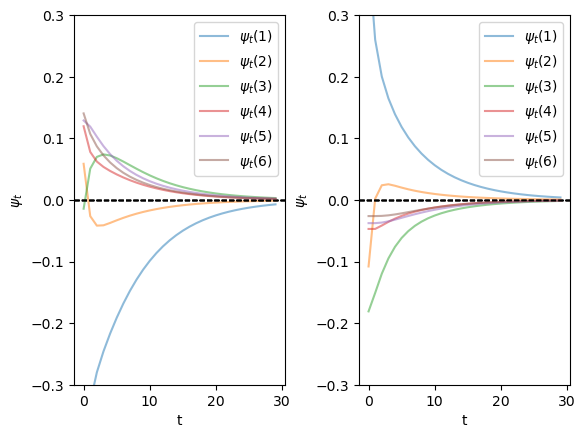

In [27]:
ts_length = 30
num_distributions = 20
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']

# 获取转移矩阵的参数
n = len(P)
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ψ_0 = np.array([[1/6 for i in range(6)],
                [0 if i != 0 else 1 for i in range(6)]])
## 绘制图像
fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0.35)
for idx in range(2):
    ψ_t = iterate_ψ(ψ_0[idx], P, ts_length)
    for i in range(n):
        axes[idx].plot(ψ_t[:, i] - ψ_star[i], alpha=0.5, label=fr'$\psi_t({i+1})$')
        axes[idx].set_ylim([-0.3, 0.3])
        axes[idx].set_xlabel('t')
        axes[idx].set_ylabel(fr'$\psi_t$')
        axes[idx].legend()
        axes[idx].axhline(0, linestyle='dashed', lw=1, color = 'black')

plt.show()

```{solution-end}
```

```{exercise}
:label: mc1_ex_3
证明以下命题：如果 $P$ 是一个随机矩阵，那么对于所有 $k \in \mathbb N$，$P^k$ 也是随机矩阵。
```

```{solution-start} mc1_ex_3
:class: dropdown
```

假设 $P$ 是随机矩阵，且 $P^k$ 是某个整数 $k$ 的随机矩阵。

我们将证明 $P^{k+1} = P P^k$ 也是随机矩阵。

（我们正在进行归纳证明——假设在 $k$ 时命题为真，并证明在 $k+1$ 时命题也为真。）

要看到这一点，注意到，由于 $P^k$ 是随机矩阵且非负矩阵的乘积是非负的，因此 $P^{k+1} = P P^k$ 是非负的。

此外，如果 $\mathbf 1$ 是全 1 列向量，那么由于 $P^k$ 是随机矩阵，我们有 $P^k \mathbf 1 = \mathbf 1$ （行和为一）。

因此 $P^{k+1} \mathbf 1 = P P^k \mathbf 1 = P \mathbf 1 = \mathbf 1$

证明完毕。

```{solution-end}
```